# CDSMOTE

## Please reference the following paper:
    
Elyan E, Moreno-García CF, Jayne C. CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification. Neural Comput Appl. 2020. <a href="https://doi.org/10.1007/s00521-020-05130-z">10.1007/s00521-020-05130-z</a>

### Bibtex Citation
@article{Elyan2020,
author = {Elyan, Eyad and Moreno-Garcia, Carlos Francisco and Jayne, Chrisina},
doi = {10.1007/s00521-020-05130-z},
isbn = {0123456789},
issn = {1433-3058},
journal = {Neural Computing and Applications},
keywords = {Class-imbalance,Classification,Imbalance Datasets,Machine,Machine learning,Oversampling,Un,Undersampling},
publisher = {Springer London},
title = {{CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification}},
url = {https://doi.org/10.1007/s00521-020-05130-z},
year = {2020}
}



## Importing the necessary modules

In [1]:
import clustData
import computeKVs
import numpy as np
import csv
import math
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

## Input parameters

In [3]:
dataset = 5 # number of dataset from the repository presented in Cleofas-Sanchez et al. 2016
classdecomp = 'Kmeans' # 'FCmeans', 'FCmeansOptimised' and 'DBSCAN' also available 
oversampler = 'SMOTE' #'ADASYN' also available
threshold = 10 # if samples in positive class are apart from average by more than this value, apply oversampling (Sec 3.2 of the paper)
n_clusters = 2 # used in options "all" and majority
k_type = 'majority' # method used for the paper, although an alternative "majorityImbalnceRatio" is also available

## Load Dataset

In [4]:
## Load dataset
with open('data//C'+str(dataset)+'.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = []
    target = []
    for row in reader:
        data.append(list(map(float,row[0:len(row)-1])))
        target.append(row[-1])
del row, reader, f

## Load dataset info from fileMatch.csv
with open('data//fileMatch.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    fileMatch_All = []
    for row in reader:
        fileMatch_All.append((int(row[0]),row[1],int(row[2]),int(row[3]),float(row[4])))
fileMatch = fileMatch_All[dataset-1]
del row, f, fileMatch_All, reader
    
## Find majority and minority classes
majority_class = max(set(target), key=target.count)
minority_class = min(set(target), key=target.count)

## Plotting the original dataset

Dataset: C5
      Class  Number of Samples
0  negative                634
1  positive                212
Total samples: 846

Showing class distribution bar chart...


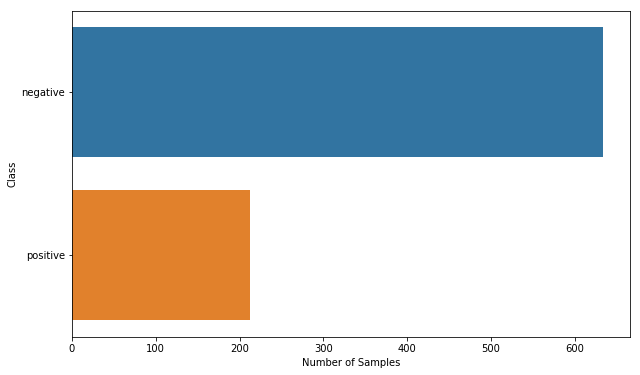

In [6]:
%matplotlib inline
print('Dataset: C'+str(dataset))
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])
## Save the histogram as a .csv file   
with open('originaldb_classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10, 6)
sns_plot.figure.savefig('originaldb_barchart'+'.jpg', orientation = 'landscape', dpi = 600)
print('\nShowing class distribution bar chart...')
plt.show()

## Applying class decomposition


Class decomposition by applying k-means...
Number of clusters for class negative: 2
No clustering performed for class positive.
         Class  Number of Samples
0  negative_c0                164
1  negative_c1                470
2  positive_c0                212
Total samples: 846
Average number of samples per class: 282.0

Showing class distribution bar chart...


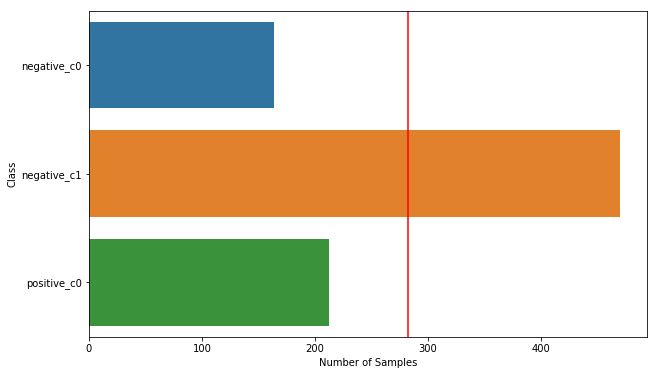

In [8]:
## Calculate k vector (for class decomposition)

if k_type.lower() == 'majority':
    k = computeKVs.majority(data, target, n_clusters)
elif k_type.lower() == 'majorityimbalanceratio':
    n_clusters = math.ceil(fileMatch[4])
    k = computeKVs.majority(data, target, n_clusters)
else:
    print('Invalid k values option for kmeansSMOTE')
    sys.exit()

## Cluster the data
if classdecomp.lower()=='kmeans':
    target_cd = clustData.Kmeans(data, target, k)
elif classdecomp.lower()=='fcmeans':
    target_cd = clustData.FCmeans(data, target, k)
elif classdecomp.lower()=='fcmeansoptimised':
     target_cd = clustData.FCmeansOptimised(data, target, k, max_nclusters = 10)   
elif classdecomp.lower()=='dbscan':        
     target_cd = clustData.DBSCAN(data, target, k, eps=0.5, min_samples=5)
else:
    print('Invalid class decomposition algorithm.')
    sys.exit()
# Plot distribution after cd
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
## Save the histogram as a .csv file   
with open('decomposeddb_classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target_cd)))
## Create a histogram using seaborn
sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
## draw a line depicting the average
indexesUnique = list(set(target_cd))
indexesUnique.sort()
newclassdist_count = []
for newclass in indexesUnique:
     newclassdist_count.append(target_cd.count(newclass))
average = sum(newclassdist_count)/len(newclassdist_count)
print('Average number of samples per class:', average)
plt.axvline(average, color='red')
## Save the image
sns_plot.figure.set_size_inches(10, 6)
sns_plot.figure.savefig('decomposeddb_barchart'+'.jpg', orientation = 'landscape', dpi = 600)
print('\nShowing class distribution bar chart...')
plt.show()

## Applying oversampling to the minority class w.r.t. the sub-class of the majority class closest to the average (red line). If the minority class is closer to the average than the `threshold`, then this step is skipped.

Oversampling original minority class...
         Class  Number of Samples
0  negative_c0                164
1  negative_c1                470
2  positive_c0                470
Total samples: 1104
New average number of samples per class: 313.3333333333333

Showing class distribution bar chart...


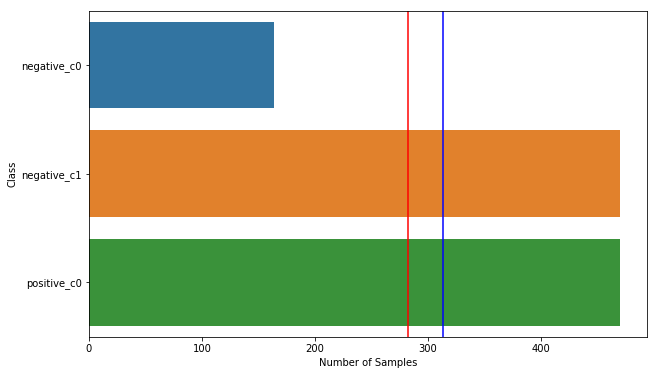

In [9]:
## 1. see if the positive is far from the average (larger than the threshold)
if abs(average-newclassdist_count[-1])>threshold:
    print('Oversampling original minority class...')
    ## 2. calculate new majority class for smote (closest to the average)
    c = np.inf
    newmaj = 0
    for i,j in enumerate(newclassdist_count[0:-1]):
        if abs(j-average)<c:
            c = abs(i-average)
            newmaj = i
    majority_class_new = majority_class+'_c'+str(newmaj)
    minority_class_new = minority_class+'_c0'
    ## 3. Create the dataset that only contains the new majority and minority classes
    data_majmin = []
    target_majmin = []
    for m, label in enumerate(target_cd):
        if label == majority_class_new or label == minority_class_new:
            data_majmin.append(data[m])
            target_majmin.append(label)
    if oversampler.lower() == 'smote':
        sm = SMOTE()
        data_over, target_over = sm.fit_resample(data_majmin, target_majmin) 
    elif oversampler.lower() == 'adasyn':
        ada = ADASYN()
        data_over, target_over = ada.fit_resample(data_majmin, target_majmin)
    else:
        print('Invalid oversampling algorithm.')
        sys.exit() 
    ## 4. combine this with the remaning classes
    data_cdsmote = data_over.copy()
    target_cdsmote = target_over.copy()
    for m, label in enumerate(target_cd):
        if label != minority_class_new and label != majority_class_new:
            data_cdsmote.append(data[m])
            target_cdsmote.append(label)
    
    
    ## Plot distribution after smote
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cdsmote)))):
        cont = 0
        for j, label2 in enumerate(target_cdsmote):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cdsmote)])
    ## Save the histogram as a .csv file   
    with open('overdb_classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        for i, hist in enumerate(histo):
            filewriter.writerow(hist)
    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cdsmote)))
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(y="Class", x="Number of Samples", data=histo_panda)
    ## draw a line depicting the average
    indexesUnique = list(set(target_cdsmote))
    indexesUnique.sort()
    newestclassdist_count = []
    for newestclass in indexesUnique:
         newestclassdist_count.append(target_over.count(newestclass))
    average_new = sum(newestclassdist_count)/len(newestclassdist_count)
    print('New average number of samples per class:', average_new)
    plt.axvline(average, color='red')
    plt.axvline(average_new, color='blue')
    ## Save the image
    sns_plot.figure.set_size_inches(10, 6)
    sns_plot.figure.savefig('overdb_barchart'+'.jpg', orientation = 'landscape', dpi = 600)
    print('\nShowing class distribution bar chart...')
    plt.show()

else:
    print('Original minority class is close to average. No oversampling needed.')


## Save the new dataset in a `.csv` file

In [10]:
## Save the new dataset
with open('C'+str(dataset)+'_'+classdecomp+'_'+oversampler+'_ktype='+k_type+'_'+'nclusters='+str(n_clusters)+'.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for j, tar in enumerate(target_cdsmote):
        row = data_cdsmote[j].copy()
        row.append(target_cdsmote[j])
        filewriter.writerow(row)